# Introduction

This tutorial will introduce you to a real-world data challenge held by Airbnb, which is to identify the patterns among their customers. Specifically, given the data of 210,000 users’ behaviors, participants were asked to predict in which country a new user will make his or her first booking. These booking behaviors of first-time users can help Airbnb better personalize their maketing tactics and increase its booking rates.

Data for this tutorial can be found at the following link. https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data

# Tutorial content

In the first part of this tutorial, I will show how to do some data explorationa and basic visualizationon Airbnb's user booking dataset, specifically using Pandas, numpy, seaborn and Matplotlib. 

In the second part, I will show a solution for airbnb's new user booking prediction challenge. I will use Xgboost and Random Forest model and perform a weighted voting for the final result.

I will cover the following topics in this tutorial:
- [Loading and exploring Airbnb's data](#Data-Exploration)
- [Data visualization using Seaborn and Matplotlib](#Data-visualization)
- [Data preprocessing and feature exatraction](#Feature-Extraction-from-Sessions)
- [Up and running with Xgboost and Random Forest](#Up-and-running-with-Random-Forest-and-Xgboost)
- [User booking prediction](#User-first-booking-prediction)

# Section 1. Visualizing the Data using Matplotlib and Seaborn

There are 2 datasets that I mainly want to talk about. First, the original file from Airbnb website, train_users_2.csv, contrains 213,451 observations that contain a variety of information such as users’ age, gender, language, date of first booking, signup methods, and device types. The correct classification result is not being published by Airbnb so it's impossible for me to verify my classification accuracy on their testing data. So I split the original training data file into training file (163,451 lines) and testing file (50,001 lines). The bash cmd for splitting is as follows.

- TERMINAL>> wc -l train_users_2.csv
- TERMINAL>> head -163451 train_users_2.csv > train_users.csv
- TERMINAL>> tail -50000 train_users_2.csv > test_users.csv # don't forget to concat the one-line header for this file. 

For the testing file, I removed the "destination_country" column and saved that column in "answer.csv", we will use this file to compare with our final classification result.

Another dataset, sessions.csv, is a detailed record of each user’s online activities on the Airbnb website. I will extracted count frequent features in the latter content (Section2).

In [1]:
import numpy as np
import pandas as pd

# Read the train and the test data 
train_users = pd.read_csv('train_users.csv')
test_users = pd.read_csv('test_users.csv')

print (train_users.head())
print ("==================================================================================================")
print (test_users.head())
print ("==================================================================================================")

# Extracting labels from the train data
train_users_labels = train_users.loc[:,'country_destination']
print (train_users_labels.head(n=5))

print ("==================================================================================================")

# Extracting attributes from the train data
train_users_attrs = train_users.iloc[:,0:15]
print(train_users_attrs.head(n=5))

           id date_account_created  timestamp_first_active date_first_booking  \
0  gxn3p5htnn           2010-06-28          20090319043255                NaN   
1  820tgsjxq7           2011-05-25          20090523174809                NaN   
2  4ft3gnwmtx           2010-09-28          20090609231247         2010-08-02   
3  bjjt8pjhuk           2011-12-05          20091031060129         2012-09-08   
4  87mebub9p4           2010-09-14          20091208061105         2010-02-18   

      gender   age signup_method  signup_flow language affiliate_channel  \
0  -unknown-   NaN      facebook            0       en            direct   
1       MALE  38.0      facebook            0       en               seo   
2     FEMALE  56.0         basic            3       en            direct   
3     FEMALE  42.0      facebook            0       en            direct   
4  -unknown-  41.0         basic            0       en            direct   

  affiliate_provider first_affiliate_tracked signup_app 

As we can see from the above code snippet and output, the dataset airbnb is quite huge. Here’s a list of what the variables actually mean.

- id: user id
- date_account_created: the date of account creation
- timestamp_first_active: timestamp of the first activity, note that it can be earlier than
- date_account_created or date_first_booking because a user can search before signing up
- date_first_booking: date of first booking
- gender
- age
- signup_method
- signup_flow: the page a user came to signup up from
- language: international language preference
- affiliate_channel: what kind of paid marketing
- affiliate_provider: where the marketing is e.g. google, craigslist, other
- first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
- signup_app
- first_device_type
- first_browser
- country_destination: this is the target variable you are to predict 

The country destination information is in training dataset but is not provided in test dataset. However, I have a answer.csv which stores the actual booking destination. So I can compare this values latter after we perform the classification algorithm. 

## Data Exploration

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function

# Draw inline
%matplotlib inline

# Set figure aesthetics
sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("poster", font_scale=1.1)

train_users = pd.read_csv("train_users.csv")
test_users = pd.read_csv('test_users.csv')
print("In total we have", train_users.shape[0] + test_users.shape[0], "users.")

# Merge train and test users
users = pd.concat((train_users, test_users), axis=0, ignore_index=True)

# Remove ID's since now we are not interested in making predictions
users.drop('id',axis=1, inplace=True)

users.head()

In total we have 213451 users.


,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,language,signup_app,signup_flow,signup_method,timestamp_first_active
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,en,Web,0,facebook,20090319043255
1,seo,google,38.0,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,en,Web,0,facebook,20090523174809
2,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,en,Web,3,basic,20090609231247
3,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,en,Web,0,facebook,20091031060129
4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,en,Web,0,basic,20091208061105


Since we have quite a lot of NaN in the age and gender wich will yield in lesser performance of the classifiers we will build. The feature date_first_booking has a 58% of NaN values because this feature is not present at the tests users, and therefore, we won't need it at the modeling part. For these kinds of unknown value, we will replace NaN in the dataframe.

In [3]:
users.gender.replace('-unknown-', np.nan, inplace=True)

In [4]:
users_nan = (users.isnull().sum() / users.shape[0]) * 100
users_nan[users_nan > 0].drop('country_destination')
users.loc[users.age > 95, 'age'] = np.nan
users.loc[users.age < 13, 'age'] = np.nan

print("Just for the sake of curiosity; we have", 
      int((train_users.date_first_booking.isnull().sum() / train_users.shape[0]) * 100), 
      "% of missing values at date_first_booking in the training data")

Just for the sake of curiosity; we have 0 % of missing values at date_first_booking in the training data


In [5]:
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'country_destination',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method'
]

for categorical_feature in categorical_features:
    users[categorical_feature] = users[categorical_feature].astype('category')

In [6]:
users.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,language,signup_app,signup_flow,signup_method,timestamp_first_active
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,NaN,en,Web,0,facebook,20090319043255
1,seo,google,38.0,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,en,Web,0,facebook,20090523174809
2,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,en,Web,3,basic,20090609231247
3,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,en,Web,0,facebook,20091031060129
4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,NaN,en,Web,0,basic,20091208061105


In [7]:
users['date_account_created'] = pd.to_datetime(users['date_account_created'])
users['date_first_booking'] = pd.to_datetime(users['date_first_booking'])
users['date_first_active'] = pd.to_datetime((users.timestamp_first_active // 1000000), format='%Y%m%d')

## Data visualization

In the previous paragraphs, I did some basic exploration on Airbnb's dataset. In this chapter, I will perform some  visualization the data based on some metric (gender, age, dates) to examine if there is any apparent correlation between country_destination (outcome variables) and those metrics.

### Gender

As we can see in the following code, we can see the ammount of missing data in perspective. 
Also, notice that there is a slight difference between user gender.

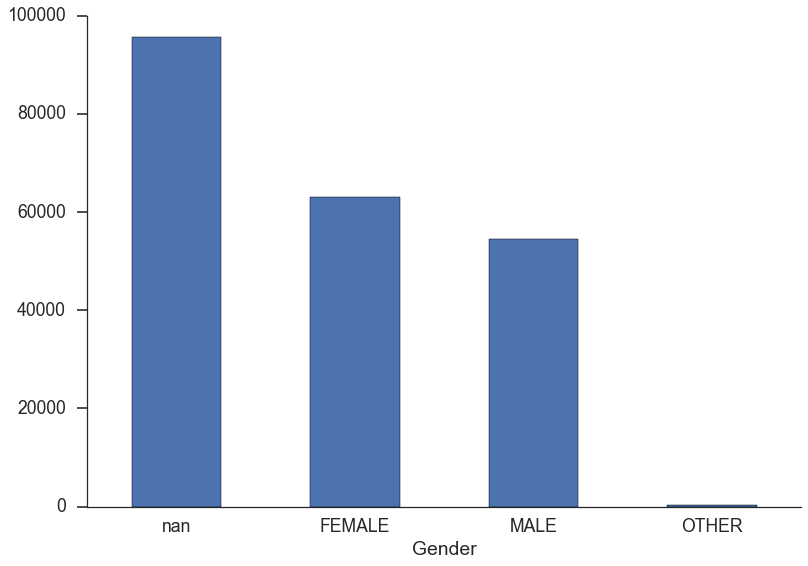

In [8]:
users.gender.value_counts()
users.gender.value_counts(dropna=False).plot(kind='bar', rot=0)
plt.xlabel('Gender')
sns.despine()

Next thing it might be interesting to see if there is any gender preferences when travelling:


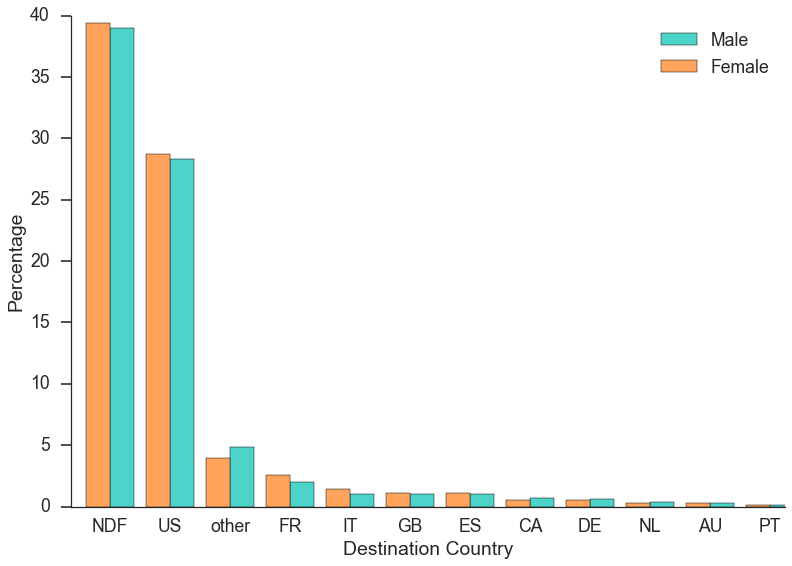

In [9]:
women = sum(users['gender'] == 'FEMALE')
men = sum(users['gender'] == 'MALE')

female_destinations = users.loc[users['gender'] == 'FEMALE', 'country_destination'].value_counts() / women * 100
male_destinations = users.loc[users['gender'] == 'MALE', 'country_destination'].value_counts() / men * 100

# Bar width
width = 0.4
male_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=0, label='Male', rot=0)
female_destinations.plot(kind='bar', width=width, color='#FFA35D', position=1, label='Female', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

### Age

Next thing it might be interesting to see if there is any age preferences when travelling:

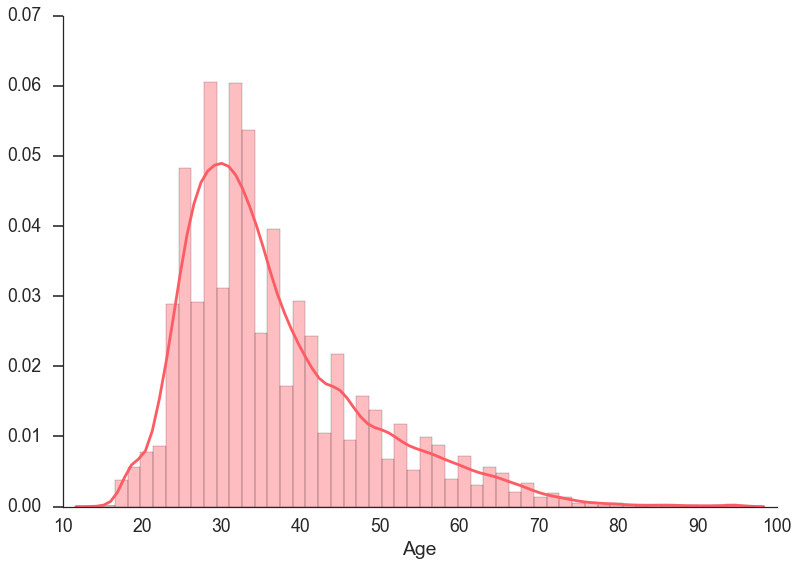

In [10]:
sns.distplot(users.age.dropna(), color='#FD5C64')
plt.xlabel('Age')
sns.despine()

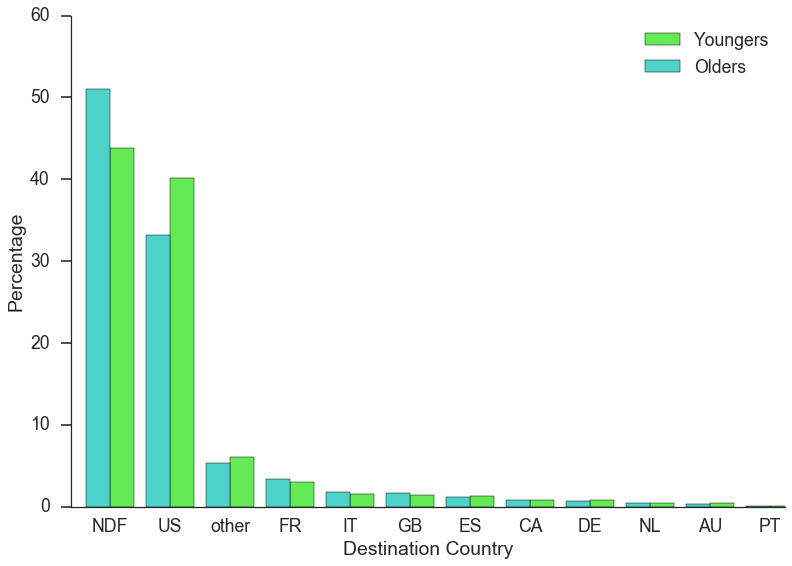

In [11]:
age = 45

younger = sum(users.loc[users['age'] < age, 'country_destination'].value_counts())
older = sum(users.loc[users['age'] > age, 'country_destination'].value_counts())

younger_destinations = users.loc[users['age'] < age, 'country_destination'].value_counts() / younger * 100
older_destinations = users.loc[users['age'] > age, 'country_destination'].value_counts() / older * 100

younger_destinations.plot(kind='bar', width=width, color='#63EA55', position=0, label='Youngers', rot=0)
older_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=1, label='Olders', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

### Dates

Likewisely, the dates information is also shown below. We can see the register user counts and booking counts increasing considerably every year. 

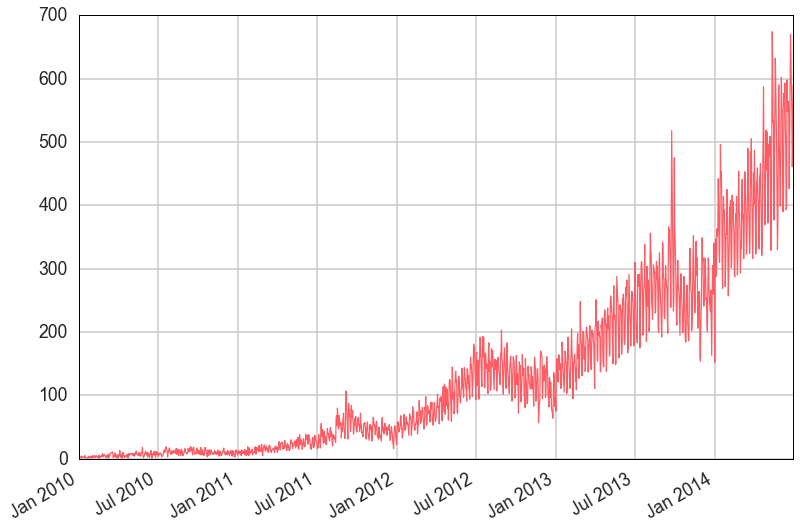

In [12]:
sns.set_style("whitegrid", {'axes.edgecolor': '0'})
sns.set_context("poster", font_scale=1.1)
users.date_account_created.value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')

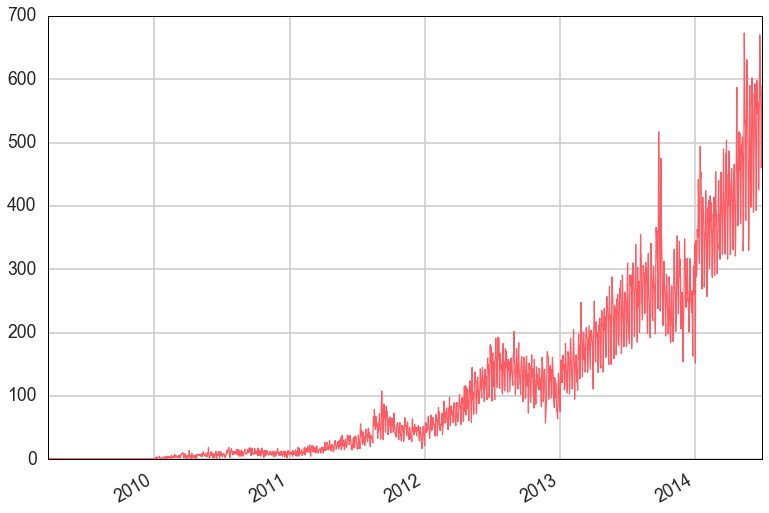

In [13]:
users.date_first_active.value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')

Now the visualization part is finished, and we can see some the relationship between independent variable and output variable. The latter part of this tutorial will discussses machine learning algorithm and user booking prediction the dataset.

# Section2. Airbnb user booking prediction using Xgboost and Random Forest

In this section, we are challenged by Airbnb to predict in which country a new user will make his or her first booking. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

In [14]:
import scipy.stats as stats
from utilities import remove_rare_values_inplace
import datetime as dt

## Feature Extraction from Sessions

In this part, we will extract frequency counts as features from the “sessions.csv” data. Since each step in the tutorial is strongly depends on previous step, I saved all the intermediate file as .CSV in the code directory.

To extract frequency counts from pd_frame, we simply perform the following steps: For each index (that correspond to a user) this method will count the number of times that C equals to Ci, where C is a column in column_list, and Ci is a unique value of that column. The arg olumn_list is assumed to contain categorical columns. Simple distribution statistics, includes mean, median standard deviation, are extracted from numerical columns.

In [15]:
INDEX_COLUMN = 'user_id'
SECS_ELAPSED_NUMERICAL = 'secs_elapsed'
CATEGORICAL_FEATURES = ['action', 'action_type', 'action_detail', 'device_type']
SESSSIONS_CSV_FILE = 'sessions.csv'
OUTPUT_TO_CSV_FILE = 'session_features.csv'  # Results will be saved here.

VALUE_THRESHOLD = 0.005

In [16]:
def extract_frequency_counts(pd_frame, column_list):
    '''
    Args:
        df_frame -- A pandas data frame.
        column_list -- A list of columns.
    Returns:
        A pandas DataFrame, containing frequency counts.
    '''
    df_extracted_sessions = []
    for col in column_list:
        for val in set(pd_frame[col]):
            print ('Extracting frequency counts for (%s == %s)' % (col, val))
            tmp_df = pd_frame.groupby(pd_frame.index).apply(
                lambda group, x=col, y=val: np.sum(group[x] == y))
            tmp_df.name = '%s=%s' % (col, val)
            df_extracted_sessions.append(tmp_df)
    frequency_counts = pd.concat(df_extracted_sessions, axis=1)
    return frequency_counts

def extract_distribution_stats(pd_frame, numerical_col):
    tmp_df = pd_frame[numerical_col].groupby(pd_frame.index).aggregate(
        [np.mean, np.std, np.median, stats.skew])
    tmp_df.columns = ['%s_%s'% (numerical_col, i) for i in tmp_df.columns]
    return tmp_df

In [17]:
# Load basic training and testing data, from CSV file.
sessions = pd.read_csv(SESSSIONS_CSV_FILE)
sessions.set_index(INDEX_COLUMN, inplace=True)
sessions.fillna(-1, inplace=True)
# Extract features from sessions.
remove_rare_values_inplace(sessions, CATEGORICAL_FEATURES, VALUE_THRESHOLD)
frequency_counts = extract_frequency_counts(sessions, CATEGORICAL_FEATURES)
simple_stats = extract_distribution_stats(sessions, SECS_ELAPSED_NUMERICAL)
# Save new data.
session_data = pd.concat((frequency_counts, simple_stats), axis=1)
session_data.fillna(-1, inplace=True)
session_data.to_csv(OUTPUT_TO_CSV_FILE)

Extracting frequency counts for (action == show)
Extracting frequency counts for (action == similar_listings)
Extracting frequency counts for (action == index)
Extracting frequency counts for (action == search_results)
Extracting frequency counts for (action == confirm_email)
Extracting frequency counts for (action == create)
Extracting frequency counts for (action == header_userpic)
Extracting frequency counts for (action == lookup)
Extracting frequency counts for (action == collections)
Extracting frequency counts for (action == requested)
Extracting frequency counts for (action == qt2)
Extracting frequency counts for (action == personalize)
Extracting frequency counts for (action == update)
Extracting frequency counts for (action == track_page_view)
Extracting frequency counts for (action == notifications)
Extracting frequency counts for (action == active)
Extracting frequency counts for (action == similar_listings_v2)
Extracting frequency counts for (action == identity)
Extracting 

In [18]:
session_data.head()

,action=show,action=similar_listings,action=index,action=search_results,action=confirm_email,action=create,action=header_userpic,action=lookup,action=collections,action=requested,...,device_type=Android App Unknown Phone/Tablet,device_type=Mac Desktop,device_type=other,device_type=iPhone,device_type=iPad Tablet,device_type=Android Phone,secs_elapsed_mean,secs_elapsed_std,secs_elapsed_median,secs_elapsed_skew
user_id,,,,,,,,,,,,,,,,,,,,,
00023iyk9l,9,3,4,1,1,0,2,0,0,5,...,0,36,0,4,0,0,21697.375000,91120.253083,843.0,5.604319
0010k6l0om,20,0,5,8,0,0,1,0,0,0,...,0,63,0,0,0,0,9310.190476,22598.464587,847.0,3.550714
001wyh0pz8,6,0,2,0,0,1,0,0,4,0,...,90,0,0,0,0,0,3144.044444,6541.232094,1104.0,4.913634
0028jgx1x1,15,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,9580.935484,17791.437472,489.0,2.864292
002qnbzfs5,232,0,115,0,1,21,2,0,0,0,...,0,0,0,775,0,0,8221.899873,58074.501937,498.0,19.436206


## Training and Testing Data preparation

After feature extraction, We will make the training and testing data ready for the classifiers. In order to perform machine learning algorithm for prediction, we need to have numerical data. However, not everything in the data frame is a number, and not all of the numbers even make sense as numerical features.
Consequently, here I'll perform some operation to transform the data into numeric format for further operation. The data processing includes:
- Dealing with missing data.
- Applying one-hot-encoding to categorical features.
- Parsing dates (and extraction of simple numerical features).
- Adding to the training and testing data the features that were extracted from sessions.csv file in the previous step.

In [19]:
LABEL = 'country_destination'
CATEGORICAL_FEATURES = ['affiliate_channel', 'affiliate_provider',
                        'first_affiliate_tracked', 'first_browser',
                        'first_device_type', 'gender', 'language', 'signup_app',
                        'signup_method', 'signup_flow']

DATE_FORMAT = '%Y-%m-%d'                # Expected format for date.
ACCOUNT_DATE = 'date_account_created'   # Date column that will be exploited.
ACCOUNT_DATE_YEAR = '%s_%s' % (ACCOUNT_DATE, 'year')
ACCOUNT_DATE_MONTH = '%s_%s' % (ACCOUNT_DATE, 'month')
UNUSED_DATE_COLUMNS = ['timestamp_first_active', 'date_first_booking']

TRAIN_DATA_BASIC = 'train_users.csv'
TEST_DATA_BASIC = 'test_users.csv'
SESSION_DATA = 'session_features.csv'
TRAINING_FINAL_CSV_FILE = 'training_features.csv'
TESTING_FINAL_CSV_FILE = 'testing_features.csv'
LABELS_FINAL_CSV_FILE = 'labels.csv'

# A parameter to speed-up computation. Categorical values that appear
# less than the threshold will be removed.
VALUE_THRESHOLD_2 = 0.001

In [20]:
def _parse_date(date_str, format_str):
    """ Extract features from the data_account_creted column.
    Args:
        date_str -- A string containing a date value.
        str_format -- The format of the string date.

    Returns:
        A list of 4 values containing the extracted [year, month, day, weekend].
    """
    time_dt = dt.datetime.strptime(date_str, format_str)
    return [time_dt.year, time_dt.month, time_dt.day, time_dt.weekday()]


def extract_dates_inplace(features, date_column):
    """ Extract from the date-columns, year, month, and other numericals.
    """
    extracted_vals = np.vstack(features[date_column].apply(
        (lambda x: _parse_date(x, DATE_FORMAT))))
    for i, period in enumerate(['year', 'month', 'day', 'weekday']):
        features['%s_%s' % (date_column, period)] = extracted_vals[:, i]
    features.drop(date_column, inplace=True, axis=1)


def apply_one_hot_encoding(pd_frame, column_list):
    """ Apply One-Hot-Encoding to pd_frame's categorical columns.
    Args:
        df_frame -- A pandas data frame.
        column_list -- A list of categorical columns, in df_frame.
    Returns:
        A pandas dataframe where the colums in column_list have been replaced
            by one-hot-encoded-columns.
    """
    new_column_list = []
    for col in column_list:
        tmp = pd.get_dummies(pd_frame[col], prefix=col)
        new_column_list.append(tmp)
    new_pd_frame = pd.concat(new_column_list+[pd_frame], axis=1)
    new_pd_frame.drop(column_list, inplace=True, axis=1)
    return new_pd_frame


def get_basic_train_test_data():
    """ Load the basic data in a pandas dataframe, and pre-process them. """
    training = pd.read_csv(TRAIN_DATA_BASIC, index_col=0)
    testing = pd.read_csv(TEST_DATA_BASIC, index_col=0)
    labels = training[LABEL].copy()
    training.drop(LABEL, inplace=True, axis=1)
    features = pd.concat((training, testing), axis=0)
    features.fillna(-1, inplace=True)

    # Process all features by removing rare values, appling one-hot-encoding to
    # those that are categorical and extracting numericals from ACCOUNT_DATE.

    remove_rare_values_inplace(features, CATEGORICAL_FEATURES, VALUE_THRESHOLD_2)
    features = apply_one_hot_encoding(features, CATEGORICAL_FEATURES)
    extract_dates_inplace(features, ACCOUNT_DATE)
    features.drop(UNUSED_DATE_COLUMNS, inplace=True, axis=1)
    return features, labels, training.index, testing.index

In [21]:
features, labels, training_ids, testing_ids = get_basic_train_test_data()
sessions = pd.read_csv(SESSION_DATA, index_col=0)
features = pd.concat((features, sessions), axis=1)
features.fillna(-1, inplace=True)
# Save data training and testing data.
training = features.ix[training_ids]
testing = features.ix[testing_ids]

# Warning: When saving the data, it's important that the header is True,
# because labels is of type pandas.core.series.Series, while training is of
# type pandas.core.frame.DataFrame, and they have different default values
# for the header argument.

assert set(training.index) == set(labels.index)
training.to_csv(TRAINING_FINAL_CSV_FILE, header=True)
testing.to_csv(TESTING_FINAL_CSV_FILE, header=True)
labels.to_csv(LABELS_FINAL_CSV_FILE, header=True)

## Up and running with Random Forest and Xgboost

Random forests is an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set.

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

For more details please view this link. http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Boosting is an ensemble technique where new models are added to correct the errors made by existing models. Models are added sequentially until no further improvements can be made. A popular example is the AdaBoost algorithm that weights data points that are hard to predict. 

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models. 

XGBoost, stands for Extreme Gradient Boosting algorithm, is the fastest implementation of gradient boosting algorithm.
For more details please see the link as follows. http://xgboost.readthedocs.io/en/latest/model.html

In this section I will show the usage of Sklearn.ensemble.RandomForestClassifier and XGBClassifier. First of all, let's import some necessary denpendency for further computation.

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier
from data_preparation import TRAINING_FINAL_CSV_FILE  # File with train data.
from data_preparation import LABELS_FINAL_CSV_FILE    # File with labels.
from data_preparation import TESTING_FINAL_CSV_FILE   # File with test data.
from data_preparation import ACCOUNT_DATE_YEAR        # Where to find year.
from data_preparation import LABEL                    # How the label is called.

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## User first booking prediction

This part will use the output of the previous step, to do the predictions.
This code used 4 classifiers:
- XGB trained on all (training) data
- RandomForests trained on all data
- XGB classifier trained on recent (aka fresh) data only
- RandomForests trained on all data only

The results from each clasifier formed the final prediction via weighted voting (5,2,10,4).

In [23]:
DEPTH_XGB, ESTIMATORS_XGB, LEARNING_XGB, SUBSAMPLE_XGB, COLSAMPLE_XGB = (
    7, 60, 0.2, 0.7, 0.6)                # XGBoost parameters.

ESTIMATORS_RF, CRITERION_RF, DEPTH_RF, MIN_LEAF_RF, JOBS_RF = (
    500, 'gini', 20, 8, 30)              # RandomForestClassifier parameters.
FRESH_DATA_YEAR = 2014                   # Year when data is considered fresh.
OUTPUT_CSV = 'final_prediction.csv'  # Where to store the predictions.

# Tunning ensemble members. The votes show the importance of each classfier
# in the final prediction.

XGB_ALL_VOTE, RF_ALL_VOTE, XGB_FRESH_VOTE, RF_FRESH_VOTE = (5, 2, 10, 4)

XGBoost provides a wrapper class to allow models to be treated like classifiers or regressors in the scikit-learn framework. We can use the full scikit-learn library with XGBoost models. The XGBoost model for classification is called XGBClassifier. We can create and and fit it to our training dataset. Models are fit using the scikit-learn API and the model.fit() function.

In [25]:
def perform_prediction(training, labels, testing, xgb_votes, rf_votes):
    """ Perform prediction using a combination of XGB and RandomForests. """
    predictions = np.zeros((len(testing), len(set(labels))))
    # Predictions using xgboost.
    for i in range(xgb_votes):
        print ('XGB vote %d' % i)
        xgb = XGBClassifier(
            max_depth=DEPTH_XGB, learning_rate=LEARNING_XGB,
            n_estimators=ESTIMATORS_XGB, objective='multi:softprob',
            subsample=SUBSAMPLE_XGB, colsample_bytree=COLSAMPLE_XGB)
        xgb.fit(training, labels)
        predictions += xgb.predict_proba(testing)
    # Predictions using RandomForestClassifier.
    for i in range(rf_votes):
        print ('RandomForest vote %d' % i)
        rand_forest = RandomForestClassifier(
            n_estimators=ESTIMATORS_RF, criterion=CRITERION_RF, n_jobs=JOBS_RF,
            max_depth=DEPTH_RF, min_samples_leaf=MIN_LEAF_RF, bootstrap=True)
        rand_forest.fit(training, labels)
        predictions += rand_forest.predict_proba(testing)
    return predictions

In [26]:
""" Perform prediction. """
train_df = pd.read_csv(TRAINING_FINAL_CSV_FILE, index_col=0)
labels_df = pd.read_csv(LABELS_FINAL_CSV_FILE, index_col=0)
test_df = pd.read_csv(TESTING_FINAL_CSV_FILE, index_col=0)
assert set(train_df.index) == set(labels_df.index)

encoder = LabelEncoder()
encoder.fit(labels_df[LABEL])
predictions = np.zeros((len(test_df), len(encoder.classes_)))

# Use the full data set for the prediction.
labels = encoder.transform(labels_df[LABEL])
predictions += perform_prediction(
    train_df, labels, test_df, XGB_ALL_VOTE, RF_ALL_VOTE)

# Use only "fresh" data for prediction. Fresh data, are considered those
# that are an ACCOUNT_DATE_YEAR equal or higher than FRESH_DATA_YEAR.

train_fresh = train_df[train_df[ACCOUNT_DATE_YEAR] >= FRESH_DATA_YEAR]
labels_fresh = encoder.transform(labels_df.ix[train_fresh.index][LABEL])
predictions += perform_prediction(
    train_fresh, labels_fresh, test_df, XGB_FRESH_VOTE, RF_FRESH_VOTE)

# Use the 5 classes with highest scores.
ids, countries = ([], [])
for i in range(len(test_df)):
    idx = test_df.index[i]
    ids += [idx]
    countries += encoder.inverse_transform(
        np.argsort(predictions[i])[::-1])[:1].tolist()

# Save prediction in CSV file.
sub = pd.DataFrame(
    np.column_stack((ids, countries)), columns=['id', 'country'])
sub.to_csv(OUTPUT_CSV, index=False)

XGB vote 0
XGB vote 1
XGB vote 2
XGB vote 3
XGB vote 4
RandomForest vote 0
RandomForest vote 1
XGB vote 0
XGB vote 1
XGB vote 2
XGB vote 3
XGB vote 4
XGB vote 5
XGB vote 6
XGB vote 7
XGB vote 8
XGB vote 9
RandomForest vote 0
RandomForest vote 1
RandomForest vote 2
RandomForest vote 3


So far, we have completed the training and testing process of Xgboost and random forest model. Both of models contribute to the final classfication result based on their weight. Now it's time to verify the accuracy of classification result!  

## Prediction Accuracy

Remember that we prepared "answer.csv" in the begining of this tutorial? Below the code to perform the comparation between our result and actual booking destination.

In [47]:
def calculate_final_accuracy(output_result, actual_result):
    """
    Args:
        output_result -- a numpy array.
        actual_result -- a numpy array.
    """
    return 1 - (float(np.sum(output_result != actual_result)))/len(output_result)

In [52]:
output = pd.read_csv(OUTPUT_CSV)
answer = pd.read_csv("answer.csv")

print (output.head())
print ("----------------------------")
print (answer.head())
print ("----------------------------")

a1 = answer["country"].values
a2 = output["country"].values
print ("The final accuracy is", calculate_final_accuracy(a1, a2))

           id country
0  f45xh1i0gr     NDF
1  uaj3wgin9n     NDF
2  f46r9nz3yp     NDF
3  wr7l2tzjj6      US
4  v4gyafqwkb     NDF
----------------------------
           id country
0  f45xh1i0gr      US
1  uaj3wgin9n     NDF
2  f46r9nz3yp     NDF
3  wr7l2tzjj6     NDF
4  v4gyafqwkb     NDF
----------------------------
The final accuracy is 0.69776


Woo-hooo! As we can see from above, the final classification accuracy is 69.78%. Not bad.

# Summary

This tutorial discusses a few interesting ideas performed on Aribnb's user booking dataset. Some key Content of this tutorial are summarized as follows.

- Splitted original Airbnb Training dataset into "train_users.csv", "test_users.csv" and "answer.csv".  
- Performed some basic visualization to show the relationship between independent variable and output variable. 
- Extracted frequency counts as features from sessions data, concated with statistics from numerical columns.
- Translated data into numeric for classifiers by dealing with missing value and applying one-hot encoding.
- Introduced sample usage of XGBClassifier and RandomForestClassifier by performing user booking classification.
- Achieved 69.78% classification accuracy.

Some comments about this challenge, which can be further explore, is as follows.

- First, the dataset of airbnb has some noise inside, so it's not easy to work with. 
- Second, the profermance of the preprocessing code is not good. It seems take me half an day for running.
- Finally, the dataset is an unbalanced dataset which has more accomodation in NDF or US, so for the locations of non-US countries, it's hard to predict.


# Reference

- Airbnb's Data Challenge https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings
- Seaborn documentation http://seaborn.pydata.org/
- XGBoost documentation https://xgboost.readthedocs.io/en/latest/
- Random Forest Wikipage https://en.wikipedia.org/wiki/Random_forest
- Top Solutions for Airbnb's data challenge
    https://github.com/Keiku/kaggle-airbnb-recruiting-new-user-bookings
    https://github.com/svegapons/kaggle_airbnb
    https://github.com/TimeMachine/Airbnb-New-User-Bookings
- Some useful links
    https://machinelearningmastery.com/xgboost-with-python/
    http://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
    http://xgboost.readthedocs.io/en/latest/model.html
    https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm